<a href="https://colab.research.google.com/github/ltabares/ClassificationCNNPneumonnia/blob/main/ClasificacionCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!git clone https://github.com/ltabares/ClassificationCNNPneumonnia.git

Cloning into 'ClassificationCNNPneumonnia'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


# Nueva sección

# **Referencies**


1.   To build a CNN using upload images

      https://www.tensorflow.org/tutorials/load_data/images

2.   Histograma de ecualización

    https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085
    https://www.youtube.com/watch?v=mSbJ1Rqhze0
3.   Rotacion de imagenes

    https://stackoverflow.com/questions65545653apply-random-shear-augment-to-image-tensor




In [ ]:
import numpy as np
import pandas as pd
import os, glob

import tensorflow as tf
#from tensorflow.keras.preprocessing.image import load_img
from keras_preprocessing.image import load_img

from PIL import Image, ImageOps 

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

from google.colab import drive
from google.colab.patches import cv2_imshow # mostrar imágenes en google colab
# Montar Google Drive y leer anotaciones
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
#Configuración

#Rutas
path_data_train = '/gdrive/MyDrive/Colab Notebooks/CNN Pneumonia/train/'
path_data_train_he = '/gdrive/MyDrive/Colab Notebooks/CNN Pneumonia/train_he/'

path_data_test = '/gdrive/MyDrive/Colab Notebooks/CNN Pneumonia/test/'
path_data_test_he = '/gdrive/MyDrive/Colab Notebooks/CNN Pneumonia/test_he/'

#Categorías
cat = ['NORMAL', 'PNEUMONIA']

#Tipo de imagenes
type_image = 'jpeg'

#Si queremos apluicar Histogramas de ecualización a las imágenes y guardarlas en una nueva carpeta.
#Esto se hace una vez sola si los datos son los mismos
eh = False

#tamaño de la imagen
size_image = 224

#Tamaño de los batch
batch_size = 15

In [ ]:
#Cantidad de datos
for cat_ in cat:
  print('Datos ' + cat_ + ' : ' + str(len(os.listdir(path_data_train + cat_))))

Datos NORMAL : 1341
Datos PNEUMONIA : 3875


In [ ]:
#Imagenes con mayor contraste

def contraste_img_eh(cat, path_data, type_image, size_image, path_data_he):
  #Creamos dos listas, una para los nombres de las imágenes y otra para las imagenes (tipo PIL).
  #Luego a cada imagen le aplicamos ecualización de histograma para hacer que la imagen tenga más contraste
  #Por último guardamos las nuevas imagenes en una nueva carpeta
  #Args:
    #cat: categoría
    #path_data: carpeta donde están las imagenes originales
    #type_image: tipo de imagen (en este caso es jpeg)
    #size_image: tamaño de la imagen
    #path_data_he: carpeta donde se guardan las imagenes nuevas a las que se le aplicó ecualización de histograma
    os.chdir(path_data + cat + '/')
    file_name_image = [file for file in glob.glob('*.' + type_image)]
    image = [load_img(path_data + cat + '/'+ x, target_size = (size_image,size_image)) for x in file_name_image]
    image_eh = list(map(ImageOps.equalize, image))
    print(file_name_image)
    for i in range(0, len(image_eh)):
      image_eh[i].save(path_data_he + cat + "/" + file_name_image[i])


In [ ]:
if eh:
  contraste_img_eh('NORMAL', path_data_train, type_image, size_image, path_data_train_he)
  contraste_img_eh('PNEUMONIA', path_data_train, type_image, size_image, path_data_train_he)
  contraste_img_eh('NORMAL', path_data_test, type_image, size_image, path_data_test_he)
  contraste_img_eh('PNEUMONIA', path_data_test, type_image, size_image, path_data_test_he)

In [ ]:
#Cantidad de datos
for cat_ in cat:
  print('Datos ' + cat_ + ' : ' + str(len(os.listdir(path_data_train_he + cat_))))

Datos NORMAL : 1341
Datos PNEUMONIA : 3875


In [ ]:
#Obtenemos los datos del directorio y generamos un objeto BatchDataset
train_data = tf.keras.utils.image_dataset_from_directory(
  path_data_train_he,
  labels = 'inferred',
  class_names= ['NORMAL', 'PNEUMONIA'],
  color_mode = 'grayscale',
  shuffle= True, 
  seed= 123,
  image_size= (size_image, size_image),
  batch_size= batch_size)


Found 5216 files belonging to 2 classes.


In [ ]:
test_data = tf.keras.utils.image_dataset_from_directory(
  path_data_test_he,
  labels = 'inferred',
  class_names= ['NORMAL', 'PNEUMONIA'],
  color_mode = 'grayscale',
  shuffle= True,
  seed= 123,
  image_size= (size_image, size_image),
  batch_size= batch_size)


y_test = np.concatenate([y for x, y in test_data], axis=0)
x_test = np.concatenate([x for x, y in test_data], axis=0)  

Found 624 files belonging to 2 classes.


In [ ]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(15, 224, 224, 1)
(15,)


In [ ]:
#Tratamiento de datos
#1)estanadarización de datos a valores entre [0,1]
#obtenemos el valor máximo de pixel que tienen los datos por supeuesto es 255
max_value = tf.reduce_max(np.array(load_img(path_data_train_he + 'NORMAL/'+ 'NORMAL2-IM-1423-0001.jpeg', target_size = (size_image,size_image)), dtype= 'float32'))
print('El valor máximo de pixel es :', max_value.numpy().max())

if max_value.numpy().max() > 1:
  rescalado = tf.keras.Sequential([tf.keras.layers.Rescaling(scale= 1./max_value.numpy().max(), offset= 0.0, name= 'rescaladoImagen')])


El valor máximo de pixel es : 255.0


In [ ]:
#2)hacemos zoom in. Los valores del zoom son negativos porque queremos aumentar de la imagen
zoom_in = tf.keras.Sequential([tf.keras.layers.RandomZoom(height_factor= [-0.05, -0.5], width_factor= [-0.05, -0.5], name= 'zoomInImagen')])


#3)rotación de imagenes. Pendiente


In [ ]:
#CNN
filtro_conv1 = 16
size_filtro1 = (5,5)
size_pool1= (2,2)

filtro_conv2 = 32
size_filtro2 = (5,5)
size_pool2= (2,2)

epocas = 5

#NN
neuron_dense1 = 120
drop_out = 0.5

num_cat = len(cat)

In [ ]:
modelo = tf.keras.Sequential([
    rescalado, 
    zoom_in,
    tf.keras.layers.Conv2D(filtro_conv1, size_filtro1, padding = 'same', activation= 'relu', name = 'conv1'), #padding = same es para que tenga el mismo tamaño que la imagen original
    tf.keras.layers.MaxPooling2D(pool_size= size_pool1, name = 'pooling1'),
    tf.keras.layers.Conv2D(filtro_conv2, size_filtro2, padding = 'same', activation= 'relu', name = 'conv2'), #padding = same es para que tenga el mismo tamaño que la imagen original
    tf.keras.layers.MaxPooling2D(pool_size= size_pool2, name = 'pooling2'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(neuron_dense1, activation = 'relu', name = 'FC1'),
    tf.keras.layers.Dropout(drop_out), #es para que active en cada paso la mitad de las neurnas, y asi evitamos el overfitting
    tf.keras.layers.Dense(num_cat, activation='softmax', name = 'output')
])

In [ ]:
modelo.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
modelo.fit(
  train_data,
  validation_data = test_data,
  epochs = epocas
)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


348/348 [==============================] - 541s 2s/step - loss: 0.4798 - accuracy: 0.7872 - val_loss: 0.9098 - val_accuracy: 0.6875
Epoch 2/5
348/348 [==============================] - 214s 616ms/step - loss: 0.3743 - accuracy: 0.8261 - val_loss: 0.6135 - val_accuracy: 0.7420
Epoch 3/5
348/348 [==============================] - 214s 616ms/step - loss: 0.3640 - accuracy: 0.8336 - val_loss: 0.5116 - val_accuracy: 0.7997
Epoch 4/5
348/348 [==============================] - 213s 611ms/step - loss: 0.3347 - accuracy: 0.8576 - val_loss: 0.6245 - val_accuracy: 0.7708
Epoch 5/5
348/348 [==============================] - 215s 616ms/step - loss: 0.3199 - accuracy: 0.8602 - val_loss: 0.6545 - val_accuracy: 0.7853


In [ ]:
y_pred = modelo.predict(x_test/255)
#y_pred es un narray de (720, 2), es decir tenemos 720 vectores de 2 dimensiones: [prob Normal, prob Pneumonia]
#mi y_pred_0 va a ser el resultados de prob Normal:
y_pred_0 = [y[0] for y in y_pred.tolist()]
y_pred_1 = [y[1] for y in y_pred.tolist()]

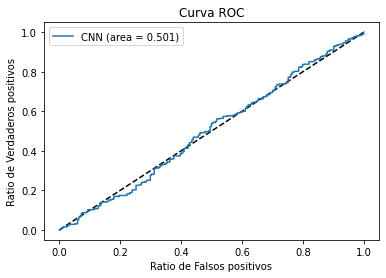

In [ ]:
fp, vp, thresholds = roc_curve(y_test, y_pred_0)

#Area bajo la curva ROC
auc1 = auc(fp, vp)

#Grafico
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fp, vp, label='CNN (area = {:.3f})'.format(auc1))
plt.xlabel('Ratio de Falsos positivos')
plt.ylabel('Ratio de Verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc='best')
plt.show()



Como vemos los resultados no son nada alentadores. Tenemos que mejorar la presición y el auc. Según este gráfico vemos que nuestro modelo es más bien un flip coin... 
Habrá que tratar un poco más los datos, por ejemplo: 

1) agregar una leve rtación e las imagenes, ya que mirando alguna de ellas se ve que no están del todo rectas

2) separar los datos de Pneumonia bacteriana de los de la virica, y hacer una clasificación a tres o quiza una clasificación: Normal Pneumonia Bacteriana y otra clasificación: Normal - Pneumonia Vírica. 

Además de analizar que CNN podemos crear.

In [ ]:
df = pd.DataFrame({'fp':fp, 'vp':vp, 'corte': thresholds})

In [ ]:
from google.colab import files
df.to_csv('output.csv', encoding = 'utf-8-sig') 
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_real_prob =pd.DataFrame({'real':y_test, 'prob_0': y_pred_0, 'prob_1': y_pred_1})

In [ ]:
df_real_prob.to_csv('df_real_prob.csv', encoding = 'utf-8-sig') 
files.download('df_real_prob.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>